# <center>HW2 矩阵分解<center>
<center>李洪君 2022214144<center>

## 1、数据预处理
+ 导入数据，将txt转化为csv的dataframe
+ 将用户从0开始编号
+ 通过数据透视函数构建 用户*电影 矩阵
+ 测试集缺失部分电影，将其补全为10000 * 10000的矩阵

调用需要用到的库

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

导入数据，将users.txt读为dataframe格式，并设置表头名称为“user_id”

In [3]:
user = pd.read_csv("users.txt", names = ['userid'])

导入netflix测试集和训练集的数据，以**空格**为分割，划分为四列，并分别命名

In [4]:
netflix_train = pd.read_csv("netflix_train.txt", sep = ' ', names = ['user_id', 'film_id', 'rating', 'date'])
netflix_test = pd.read_csv("netflix_test.txt", sep = ' ', names = ['user_id', 'film_id', 'rating', 'date'])

在user的df中建立新的一列序号，列名为"id"

In [5]:
user['id'] = range(len(user))

将user和netflix的两个df的同名用户分别merge到一起

In [6]:
netflix_train = netflix_train.merge(user, left_on='user_id', right_on='userid')
netflix_test = netflix_test.merge(user, left_on='user_id', right_on='userid')

使用pivot在两个df中抽取出关于X的训练集和测试集, 建立关于user_id与film_id之间基于rating的关系矩阵

In [7]:
X_train = netflix_train.pivot(index='id', columns='film_id', values='rating')
X_test = netflix_test.pivot(index='id', columns='film_id', values='rating')

由于建立的X的测试机和训练集之间存在遗漏数据，因此需要将其补全为10000 * 10000的矩阵

In [8]:
for i in range(1, 10001):
    if i not in X_test.columns:
        X_test[i] = np.nan

按column方向升序

In [9]:
X_test = X_test.sort_index(axis=1)

print 查看数据形式

In [ ]:
print(X_train.head())
print(X_test.head())

**选用全量数据，并已将原始的数据集整理为待训练数据，即输出为两个矩阵$X_{train}$和$X_{test}$**

上方代码为便于文字说明，未采用函数封装。考虑到矩阵分析时仍需进行数据预处理（在协同过滤的时候数据集有变化），为便于直接函数调用，此处补充数据预处理的函数：

In [11]:
def preprocess():
    user = pd.read_csv("users.txt", names = ['userid'])
    netflix_train = pd.read_csv("netflix_train.txt", sep = ' ', names = ['user_id', 'film_id', 'rating', 'date'])
    netflix_test = pd.read_csv("netflix_test.txt", sep = ' ', names = ['user_id', 'film_id', 'rating', 'date'])

    user['id'] = range(len(user))

    netflix_train = netflix_train.merge(user, left_on='user_id', right_on='userid')
    netflix_test = netflix_test.merge(user, left_on='user_id', right_on='userid')

    X_train = netflix_train.pivot(index='id', columns='film_id', values='rating')
    X_test = netflix_test.pivot(index='id', columns='film_id', values='rating')

    for i in range(1, 10001):
        if i not in X_test.columns:
            X_test[i] = np.nan

    X_test = X_test.sort_index(axis=1)
    return X_test,X_train

## 2、协同过滤
+ 基于用户的协同过滤算法：判断用户$i$是否喜欢电影$j$，只要看与$i$相似的用户，看他们是否喜欢电影$j$，并根据相似度对他们的打分进行加权平均，即：

$$
\operatorname{score} (i, j)=\frac{\sum_k\{\operatorname{sim}[\mathbf{X}(i), \mathbf{X}(k)] \cdot \operatorname{score}(k, j)\}}{\sum_k \operatorname{sim}[\mathbf{X}(i), \mathbf{X}(k)]}
$$

+ $X_{(i)}$表示用户$i$对所有电影的打分，即$X$矩阵中第$i$行对应的10000维向量，未知记为0

+ $sim[X(i),X(k)]$表示用户$i$和用户$k$对于电影打分的相似度，即：

$$
\cos (\mathbf{x}, \mathbf{y})=\frac{\mathbf{x} \cdot \mathbf{y}}{|\mathbf{x} \mid \cdot| \mathbf{y}\mid}
$$



+ 但该方法存在局部效应，因此对其进行改进，即：


$$
\hat{r}_{x i}=b_{x i}+\frac{\sum_{j \in N(i ; x)} s_{i j} \cdot\left(r_{x j}-b_{x j}\right)}{\sum_{j \in N(i ; x)} s_{i j}}
$$

$$
b_{x i} = \mu + b_{x} + b_{i}
$$

其中$\mu$是总体评分的均值，$b_{x}$是用户排名的偏差，$b_{i}$是电影排名的偏差

+ 即${score} (i, j)$公式中${score}(k, j)$这一项需要减去$b_{x i}$作为修正

In [ ]:
mu = np.mean(np.mean(X_train))
bx = np.array(np.mean(X_train, axis=1) - mu)
bi = np.array(np.mean(X_train, axis=0) - mu)

标准化矩阵

In [13]:
X = X_train.sub(bx+mu, axis=0)
X = X.div(np.sqrt(np.sum(np.square(X), axis=1)), axis=0)

将矩阵中的NaN值补0

In [14]:
X.fillna(0, inplace=True)

通过cosine建立相似矩阵similarity_matrix

In [15]:
similarity_matrix = np.dot(X, X.T)

使用协同过滤方法对矩阵进行计算

对X_train进行补0

In [16]:
X_train = np.array(X_train.fillna(0))

+ 首先用argsort()函数求出与用户i最相似的用户，按照相似度倒序排列成列表indexs

+ 其次按照列表indexs进行遍历，找出看过此电影的**相似度排名前三**的用户并计算对电影评分的加权平均值作为该用户的评分

In [17]:
for i in range(X_train.shape[0]):  # 列 用户
    indexs = np.argsort(similarity_matrix[i, :])[::-1]
    # argsort()函数是将x中的元素从小到大排列，提取其对应的index(索引)，然后输出到y。例如：x[3]=-1最小，所以y[0]=3,x[5]=9最大，所以y[5]=5。
    # 相当于用每一个flim的value把users排序了，然后提取users的序号
    for j in range(X_train.shape[1]): # 行 电影评分
        if X_train[i, j] == 0:
            sum = 0
            num = 0
            simi = 0
            k = 0
            while num < 3 & k < X_train.shape[1]:    # 计算sum和simi
                if X_train[indexs[k], j] > 0:
                    sum = sum + similarity_matrix[i, indexs[k]] * (X_train[indexs[k], j] - mu - bx[indexs[k]] - bi[j])
                    simi = simi + similarity_matrix[i, indexs[k]]
                    k = k+1
                    num = num + 1
                else:
                    k = k+1
            if simi != 0:
                X_train[i, j] = mu + bx[i] + bi[j] + sum/simi
            else:
                X_train[i, j] = mu + bx[i] + bi[j]
        else:
            continue # 跳过X_train[i, j] != 0, 进入到下一个for loop

## 3、评价指标
+ 采用$RMSE$(Root Mean Square Error，均方根误差)作为评价指标，即：

$$
R M S E=\sqrt{\frac{1}{n}\left(\sum_{<i, j>\in T e s t}\left(\mathbf{X}_{i j}-\widetilde{\mathbf{X}}_{i j}\right)^2\right)}
$$

采用for计算RMSE

In [18]:
sum = 0
for index, rows in netflix_test.iterrows():
    # python对dataframe处理时可用for循环中的迭代器dataframe.iterrows()：
    sum = sum + np.square(X_train[rows['id'], rows['film_id']-1] - rows['rating'])
    
RMSE = np.sqrt(sum/netflix_test.shape[0])
print(RMSE)

1.0133740135607885


采用矩阵计算RMSE。for循环耗时平均34.5s，矩阵计算耗时平均2.4s,可以看出所用时间更短。与for循环计算的结果一致，相互验证。

In [19]:
RMSE = np.sqrt(np.sum(np.sum(np.square(X_train - X_test)))/netflix_test.shape[0])
print(RMSE)

1.0133740135607776


设置基线误差，即当所有预测分数取平均值3的时候，计算其RMSE，进而与协同过滤算法的结果进行比较分析

In [20]:
X_train_base = netflix_train.pivot(index='id', columns='film_id', values='rating')
X_train_base = np.array(X_train_base.fillna(3))

RMSE_base = np.sqrt(np.sum(np.sum(np.square(X_train_base - X_test)))/netflix_test.shape[0])
print(RMSE_base)

1.1715111196739934


**协同过滤算法的RMSE为1.013，相比于基线误差1.1715降低了13.5%**

## 4、基于梯度下降的矩阵分解算法
+ 目标函数为：

$$
J=\frac{1}{2}\left\|\mathbf{A}^{\circ}\left(\mathbf{X}-\mathbf{U V}^T\right)\right\|_F^2+\lambda\|\mathbf{U}\|_F^2+\lambda\|\mathbf{V}\|_F^2
$$

+ 其中，$A$是指示矩阵，$A_{ij} = 1$意味着$X_{ij}$的值为已知，反之亦然。$\circ$是阿达马积，$\|\cdot\|_F$表示矩阵的Frobeniu范数，即$\|\mathbf{A}\|_F=\sqrt{\sum_i \sum_j \mathbf{A}_{i j}^2}$。

+ 目标函数第一项为预测值和真实值之间的误差，后两项为防止过拟合的正则项。

由于协同过滤的过程中改变了$X_{train}$和$X_{test}$的值，因此按照数据预处理的相同过程，调用数据预处理函数，重新构建所需的矩阵。

In [21]:
X_test, X_train = preprocess()

设置学习率，构造目标函数矩阵

In [22]:
A = X_train > 0
X_train = np.array(X_train.fillna(0))
alpha = 0.0001

In [23]:
# U1 V1 lamda1
def MD(iter, k, lambda1):
    J = np.zeros((iter,1))
    RMSE = np.zeros((iter,1))
    U = np.random.randn(10000, k)* 0.1
    V = np.random.randn(10000, k)* 0.1
    for i in range(iter):
        dU = np.dot(np.multiply(A, (np.dot(U, V.T) - X_train)), V) + 2 * lambda1 * U
        dV = np.dot(np.multiply(A, (np.dot(U, V.T) - X_train)), V) + 2 * lambda1 * V

        U = U - alpha/(1+0.1*i) * dU
        V = V - alpha/(1+0.1*i) * dV

        J[i, 0] = 1/2*np.sum(np.sum(np.square(np.multiply(A, (X_train - np.dot(U, V.T)))))) + lambda1 * np.sum(np.sum(np.square(U)))\
           + lambda1 * np.sum(np.sum(np.square(V)))

        RMSE[i, 0] = np.sqrt(np.sum(np.sum(np.square(np.dot(U, V.T) - X_test)))/netflix_test.shape[0])
        
    
    print("当k =",k,"lambda =", lambda1,"时，RMSE为",RMSE[i, 0])
    # 计算RMSE并比较
    label_name = str(k)+ " " +str(lambda1)
    plt.rcParams['figure.figsize']=(14, 17)
    # 绘制损失函数和RMSE的变化
    plt.figure(1)
    plt.subplot(211)
    plt.plot(range(iter), J[:, 0], label=label_name)
    plt.legend(loc='upper right')
    plt.xlabel("iter")
    plt.ylabel("cost_function")

    plt.subplot(212)
    plt.plot(range(iter), RMSE[:, 0], label=label_name)
    plt.legend(loc='upper right')
    plt.xlabel("iter")
    plt.ylabel("RMSE")
    


对于给定$k = 50$, $\lambda = 0.01$的情况，先作出迭代过程中目标函数值和测试集上$RMSE$的变化，给出最终的$RMSE$

当k = 50 lambda = 0.01 时，RMSE为 1.108467886982638


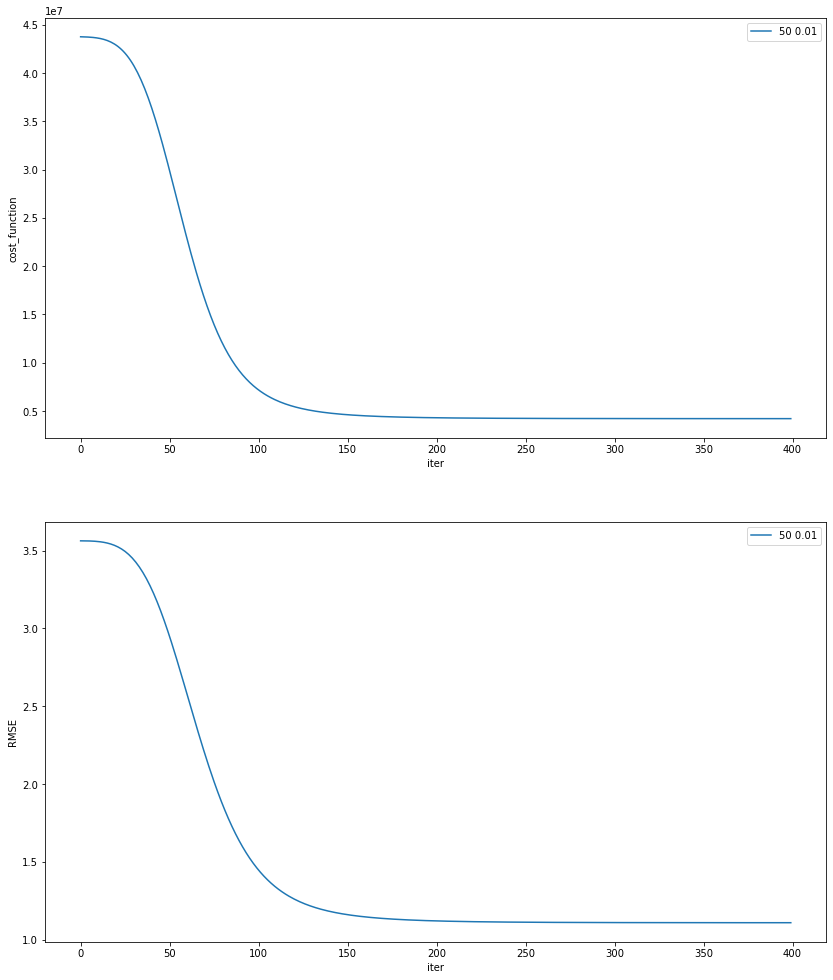

In [24]:
# iter = 400, k = 50, lamda = 0.01
MD(400, 50, 0.01)

对$k$, $\lambda$的值进行调整，比较最终$RMSE$的效果

当k = 20 lambda = 0.001 时，RMSE为 1.1233525523659975
当k = 20 lambda = 0.01 时，RMSE为 1.1325290274541036
当k = 20 lambda = 0.1 时，RMSE为 1.1309687263101051
当k = 50 lambda = 0.001 时，RMSE为 1.1253576456324121
当k = 50 lambda = 0.01 时，RMSE为 1.117989035701043
当k = 50 lambda = 0.1 时，RMSE为 1.1156805338154705


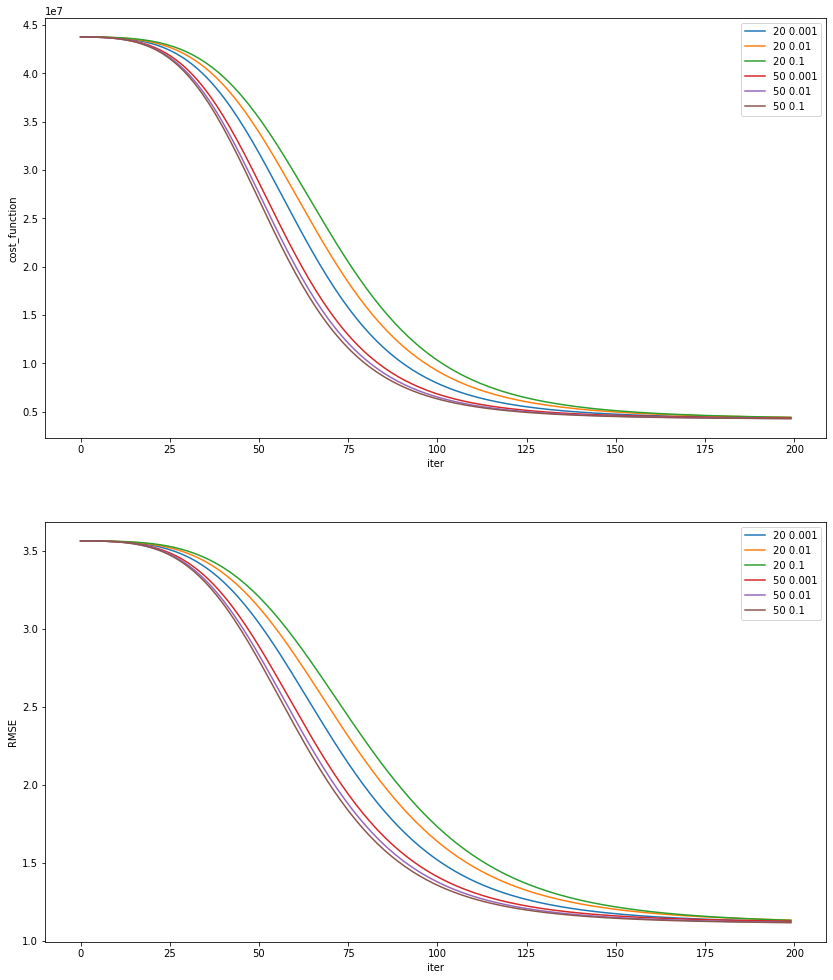

In [25]:
iter = 200
k = [20, 50]
lamda = [0.001, 0.01, 0.1]

for i in k:
    for j in lamda:
        MD(iter, i, j)

从图中我们可以观察到，不同参数对梯度下降曲线的主要影响在200步之前，后面的迭代都稳定在了近似数值。<br>
且当$k = 50$,$\lambda = 0.1$时，梯度下降的速度相对较快，因此可作为最优的参数组合。

## 5、协同过滤与矩阵分解算法的比较

#### **结果对比**
+ 时间：协同过滤算法只需要1分多钟就能运行完，但矩阵分解需要运行半个多小时；
+ 效果：与基线误差相比，协同过滤的$RMSE$能够降低13.5%，而矩阵分解仅仅降低了5%

#### **优缺点**

##### 协同过滤
+ 优点
    + 无需领域知识，embedding是自动学习得到的
    + 相比机器学习系统，协同过滤可以通过相似用户的到推荐项目
    + 不需要上下文特征

+ 缺点
    + 如果类似本题，基于用户做协同过滤，那么存在数据量大，储存开销大，同时用户的历史数据很稀疏，找到相似用户的准确度很低；
    + 热门的物品会产生头部效应，容易和大量物品产生相似性
    + 仅仅利用用户和物品的交互信息，造成了信息泄露


##### 矩阵分解
+ 优点
    + 泛化能力强，一定程度上解决了数据稀疏问题；
    + 空间复杂度低；
    + 更好的扩展性和灵活性。
+ 缺点
    + 从本题的时间比较可得出，矩阵分解明显更费时；
    + 解释性相对较差，因为将用户和电影映射到了隐因子空间。


### 参考文献

[1] https://zhuanlan.zhihu.com/p/275873029 <br>
[2] https://github.com/zhangjx831/Recommender-System<br>
[3] https://blog.csdn.net/wacfucker/article/details/123648429 <br>
[4] https://blog.csdn.net/uncle_ll/article/details/95510900 <br>
[5] https://blog.csdn.net/yuanninesuns/article/details/111875110